# Figure 4

### TODO: make sure code works

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.collections import LineCollection

from src.theory import fixed_point
from src.theory import c_map
from src.theory import c_map_slope
from src.theory import depth
from src.theory import critical_point
from src.theory import depth_scale

# mpl.rcParams['figure.figsize'] = [14.0, 6.0]
matplotlib.rcParams['font.size'] = 100

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

In [17]:
def plot(dataset):
    rates = np.linspace(0.1, 1, 100)
    mu2s = 1/rates
    fps = []
    fp_slopes = []
    for p in rates:
        mu2 = 1/p
        fpoint = fixed_point(c_map, p, p*2, mu2)
        fps.append(fpoint)

        slope = c_map_slope(fpoint, p*2)
        fp_slopes.append(slope)

    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
    pickle_in = open("src/results/under_overflow.pk","rb")
#     example_dict = pickle.load(pickle_in)[:120]
    example_dict = np.load("src/results/variance_depth/{}/variance_depth.npy".format(dataset.replace("-", "")))
    # example_dict = np.load("src/results/variance_depth/cifar10/variance_depth.npy")
    inits = np.load("src/results/variance_depth/{}/variance_depth_sigma.npy".format(dataset.replace("-", "")))
    # inits = np.load("src/results/variance_depth/cifar10/variance_depth_sigma.npy")
    p = 0.6
    num_layers = 1000
    nets = np.linspace(10, num_layers, 1000, dtype=int)
    # nets = np.linspace(10, num_layers, 12, dtype=int)[:10]
    # inits = np.round(np.linspace(0.1, 2.5, 12),1)
    xv, yv = np.meshgrid(nets, inits, sparse=False, indexing='ij')

    Z1 = np.log(np.array(example_dict))

    bad_indices = np.isnan(Z1) + np.isinf(Z1)
    Z1 = np.ma.array(Z1, mask=bad_indices)
    cmap = matplotlib.cm.get_cmap(name="Spectral_r")
    cmap.set_bad('white', 1.)

    pcm = ax1.pcolormesh(yv-0.05, xv, Z1.T, cmap=cmap)
    cbar = fig.colorbar(pcm, ax=ax1, extend='max')
    cbar.ax.set_title('$log(q^l)$')

    ax1.set_xlabel('Weight initialisation ($\sigma^2_w$)')

    ax1.set_ylabel("Number of layers")
    ax1.set_title("{} - Variance propagation depth:\ndropout with $p$ = 0.6, crit. init. at $\sigma^2_w = 1.2$".format(dataset.upper()))

    max_depth = 0
    init_theory = np.linspace(0, 2.4, 1000)
    depth_per_p_theory = depth("Dropout", init_theory, p)
    max_depth = np.max([max_depth, np.max(depth_per_p_theory)])
    ax1.plot(init_theory, depth_per_p_theory, label="Theory", c='cyan', linewidth=3)

    # plot critical point
    crit_point = critical_point("Dropout", p)
    ax1.plot([crit_point,]*2, [0, num_layers], color="black", linestyle="--", label="criticality")

    ax1.set_ylim(0, 1000)
    ax1.legend()
    ax1.set_xticks(inits[:-1:2])
    ax1.text(0.1, 400, 'Underflow', fontsize=20)
    ax1.text(1.7, 400, 'Overflow', fontsize=20)

    # pickle_in = open("src/results/val_loss_per_depth.pk","rb")
    # example_dict = np.array(pickle.load(pickle_in))[:,1]
    rates = np.linspace(0.1, 1, 100)

    example_dict = np.load("src/results/trainable_depth/{}/trainable_depth.npy".format(dataset.replace("-", "")))
    # p_depths = np.load("src/results/trainable_depth/mnist/trainable_depth_p_depth.npy")

    example_dict = np.min(example_dict[:, :, :, 1], axis=-1).T
    # xv = p_depths[:, :, 0]
    # yv = p_depths[:, :, 1]

    # print(xv)
    # mask = example_dict != 0

    # print(example_dict)

    nets = np.linspace(2, 40, 10, dtype=int)
    d_rates = 2*np.linspace(0.1, 1, 10)
    xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

    Z1 = np.array(example_dict)
    pcm = ax2.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r')
    cbar1 = fig.colorbar(pcm, ax=ax2, extend='max')
    cbar1.ax.set_title('Val. loss')

    # Now do a second plot coloring the curve using a continuous colormap
    t = rates #np.linspace(0, 10, 200)
    x = 2*rates
    y = 6*depth_scale(fp_slopes)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
    lc.set_array(t)
    lc.set_linewidth(3)
    cbar2 = fig.colorbar(lc, ax=ax2)
    cbar2.ax.set_title('p')

    ax2.add_collection(lc)
    ax2.set_xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
    ax2.set_ylabel("Number of layers")
    ax2.text(1.5, 19, r'$6\xi_c$', fontsize=20, color="white")
    ax2.set_title("{} - Depth at criticality".format(dataset.upper()))
    ax2.set_xlim(0.3, 2.1)
    ax2.set_ylim(2, 40)

    ##############
    # add labels #
    ##############
    fig.text(0.03, 0.9, "(a)", fontsize=20)
    fig.text(0.5, 0.9, "(b)", fontsize=20)

    # plt.show()
    plt.gcf().tight_layout()
    plt.savefig("{}_depth_scales.pdf".format(dataset), dpi=200)

/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:206: RuntimeWarning: divide by zero encountered in log10
  ret_val[shrinking_ps] = (np.log10(shrink_value) - np.log10(q_0))/np.log10(growth_rate[shrinking_ps])
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:249: RuntimeWarning: divide by zero encountered in true_divide
  return -1/(np.log(xi))
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:206: RuntimeWarning: divide by zero encountered in log10
  ret_val[shrinking_ps] = (np.log10(shrink_value) - np.log10(q_0))/np.log10(growth_rate[shrinking_ps])
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:249: RuntimeWarning: divide by zero encountered in true_divide
  return -1/(np.log(xi))


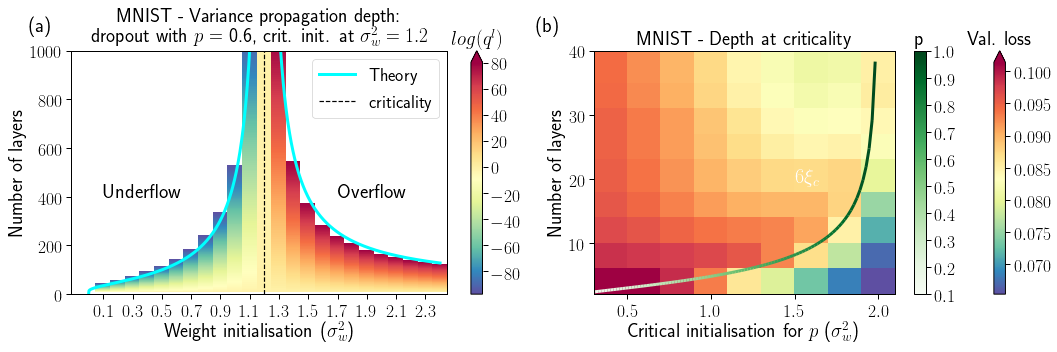

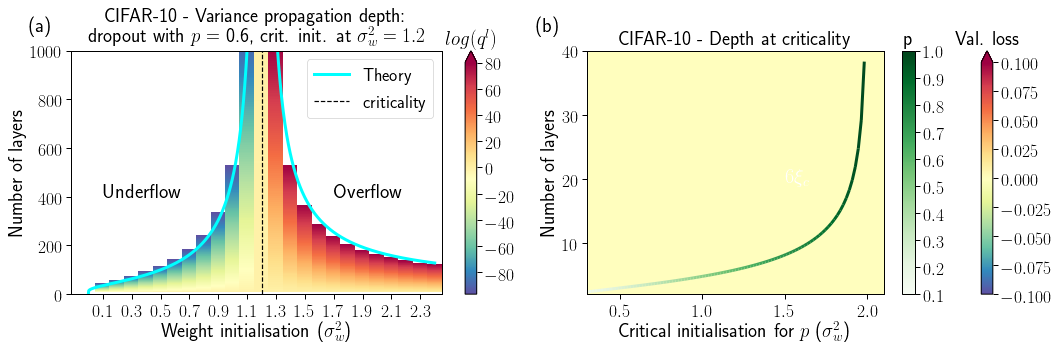

In [18]:
plot("mnist")
plot("cifar-10")

In [11]:
# data = np.load("src/results/trainable_depth/mnist/trainable_depth.npy")

# def plot(epoch):
#     rates = np.linspace(0.1, 1, 100)
#     mu2s = 1/rates
#     fps = []
#     fp_slopes = []
#     for p in rates:
#         mu2 = 1/p
#         fpoint = fixed_point(c_map, p, p*2, mu2)
#         fps.append(fpoint)

#         slope = c_map_slope(fpoint, p*2)
#         fp_slopes.append(slope)

#     fig, ax2 = plt.subplots(1, 1, figsize=(7, 5))
    
#     rates = np.linspace(0.1, 1, 100)

#     example_dict = np.min(data[:, :, :, 1], axis=-1).T
#     print(example_dict.shape)
# #     example_dict = data[:, :, epoch, 1].T
#     example_dict[example_dict == 0] = 0.085
    
#     nets = np.linspace(2, 40, 10, dtype=int)
#     d_rates = 2*np.linspace(0.1, 1, 10)
#     xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

#     Z1 = np.array(example_dict)
#     pcm = ax2.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r')
#     cbar1 = fig.colorbar(pcm, ax=ax2, extend='max')
#     cbar1.ax.set_title('Val. loss')

#     # Now do a second plot coloring the curve using a continuous colormap
#     t = rates #np.linspace(0, 10, 200)
#     x = 2*rates
#     y = 6*depth_scale(fp_slopes)
#     points = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
#     lc.set_array(t)
#     lc.set_linewidth(3)
#     cbar2 = fig.colorbar(lc, ax=ax2)
#     cbar2.ax.set_title('p')

#     ax2.add_collection(lc)
#     ax2.set_xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
#     ax2.set_ylabel("Number of layers")
#     ax2.text(1.5, 19, r'$6\xi_c$', fontsize=20, color="white")
#     ax2.set_title("Depth at criticality")
#     ax2.set_xlim(0.3, 2.1)
#     ax2.set_ylim(2, 40)
    
# import ipywidgets as widgets
# widgets.interact(plot, epoch=(0, 199))

interactive(children=(IntSlider(value=99, description='epoch', max=199), Output()), _dom_classes=('widget-inte…

<function __main__.plot(epoch)>